In [52]:
import os
import re
import models
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data_bundler import DataBundler
from torch.nn.functional import mse_loss
from sklearn.metrics import roc_curve, auc


In [48]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: False
Number of GPUs: 0
Current device: CPU
Device name: N/A
Using device: cpu


In [49]:
model = models.BaselineAutoencoder()
model.load_state_dict(torch.load("saved_models/saved_model_6.pth"))

<All keys matched successfully>

In [50]:
def evaluate_model(testing_input_features, model):
    testing_output_features = []
    mse_list = []

    model.eval()
    total_mse = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in testing_input_features:
            input = data.to(device)
            output = model(input)

            testing_output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            
    average_mse = total_mse / total_samples
    #print(f"Average MSE: {average_mse:.4f}")

    return average_mse, testing_output_features

In [51]:
data_bundler = DataBundler()
print("Testing Data")

machines = ["bearing", "fan", "gearbox", "slider", "ToyCar", "ToyTrain", "valve"]
roc_fprs = []
roc_tprs = []
auc_scores = []

for i in range(7):
    print(f"Testing machine: {machines[i]}")
    my_inclusion_string = f"{machines[i]}\\test"
    my_test_pct = 1
    testing_data, testing_filenames, testing_clip_lengths = data_bundler.load_dataset(inclusion_string=my_inclusion_string, include_supplemental=False, percentage=my_test_pct)

    testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
    testing_input_features = DataLoader(testing_dataset, batch_size=256, shuffle=False)

    average_mse, testing_output_features = evaluate_model(testing_input_features, model)
    testing_output_features = np.vstack(testing_output_features)

    original_clips = []
    start_index = 0
    for size in testing_clip_lengths:
        end_index = start_index + size
        original_clips.append(testing_data[start_index:end_index])
        start_index = end_index

    reconstructed_clips = []
    start_index = 0
    for size in testing_clip_lengths:
        end_index = start_index + size
        reconstructed_clips.append(testing_output_features[start_index:end_index])
        start_index = end_index

    recon_err_per_clip = []
    for i in range(len(reconstructed_clips)):
        item1 = reconstructed_clips[i].reshape(-1)
        item2 = original_clips[i].reshape(-1)
        
        recon_err_per_clip.append(np.mean((item1 - item2)**2))

    status_list = []
    pattern = r"_(normal|anomaly)_"
    for line in testing_filenames:
        match = re.search(pattern, line)
        if match:
            status_list.append(match.group(1))
    status_list

    output_with_true_labels = list(zip(status_list, recon_err_per_clip))
    sorted_output = sorted(output_with_true_labels, key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_output)

    binary_labels = [1 if label == 'anomaly' else 0 for label in labels]

    roc_fpr, roc_tpr, thresholds = roc_curve(binary_labels, values)
    auc_score = auc(roc_fpr, roc_tpr)
    roc_fprs.append(roc_fpr)
    roc_tprs.append(roc_tpr)
    auc_scores.append(auc_score)

Testing Data
Testing machine: bearing


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 117.34file/s]


Done loading!
Length of dataset: 12400

Testing machine: fan


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 159.73file/s]


Done loading!
Length of dataset: 12400

Testing machine: gearbox


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 125.57file/s]


Done loading!
Length of dataset: 12400

Testing machine: slider


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 149.06file/s]


Done loading!
Length of dataset: 12400

Testing machine: ToyCar


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 152.23file/s]


Done loading!
Length of dataset: 15000

Testing machine: ToyTrain


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 137.99file/s]


Done loading!
Length of dataset: 15000

Testing machine: valve


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 149.28file/s]


Done loading!
Length of dataset: 12400



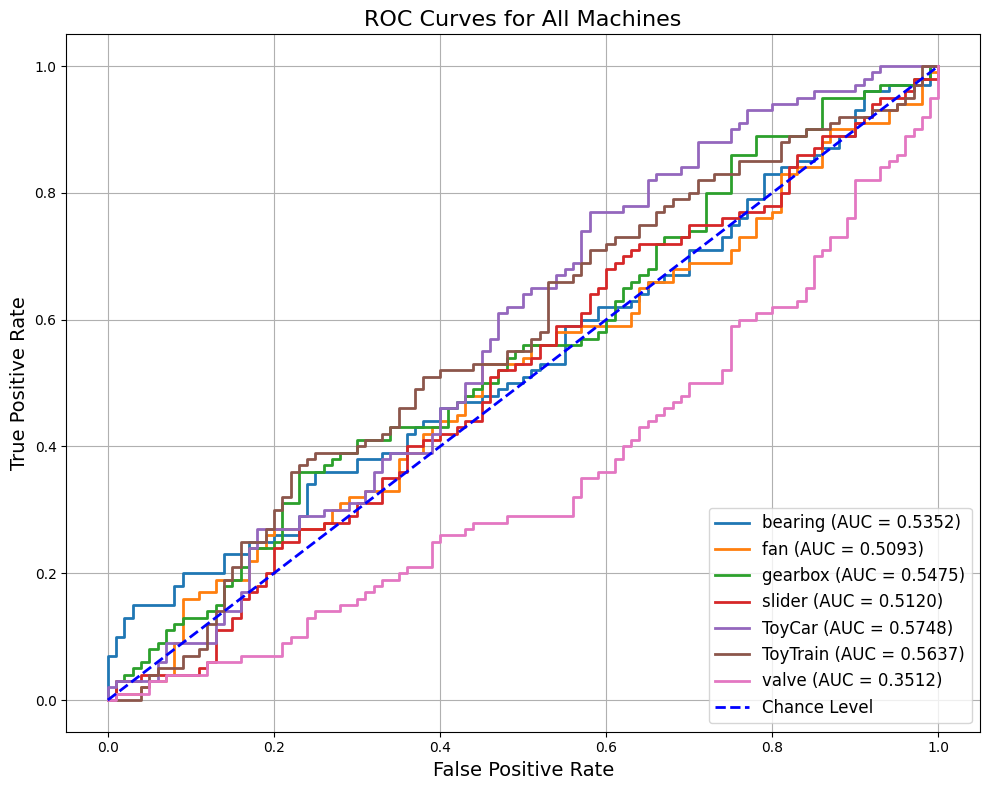

In [54]:
plt.figure(figsize=(10, 8))

for i, machine in enumerate(machines):
    plt.plot(roc_fprs[i], roc_tprs[i], lw=2, label=f'{machine} (AUC = {auc_scores[i]:.4f})')

# Plot chance level line
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')

# Customize the plot
plt.title('ROC Curves for All Machines', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()